# Semi Parammetric Latent Factor Model

### Model   $Y=\phi * u + \sigma^2I$
##### Where, $\phi \in R ^{cxp}, u \in R^{pxn}$ and $Y \in R^{cxn}$
##### Also, $u_p \in GP(0,K^p)$ where $K^p$ is the covariance kernel for that particular gaussian process


In [127]:
### necessary Imports
import numpy as np
import pylab as pb
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### True Model:

Here we generate our data that we can later use to check our solution

#### $\phi \in N(0,I)$

#### $u$
First we have similar kernels so that processes can be easily distinguished
We choose one as a exponential quad Kernel with shorter length scale.

Phi
[[ 2.07739991  0.59363349]
 [ 3.66795086  1.66843035]
 [-0.17290206  1.70179169]]


<matplotlib.colorbar.Colorbar instance at 0x7efbdaef1950>

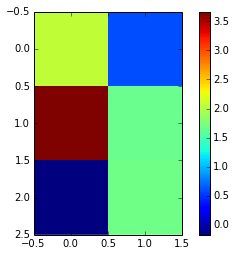

In [144]:
P = 2
C = 3
N = 50
s2 = 0.5
x = np.linspace(0,1,n)
phi = np.random.normal(loc=2.5,scale=2,size=(C,P))
print "Phi\n",phi
plt.imshow(phi,interpolation='none')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7efbdac08908>

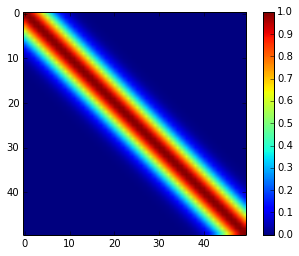

In [230]:
class Kernel:
    @staticmethod
    def exponenQuad(x,xprime,a=1,l=0.5,**kwargs):
        if kwargs:
            if kwargs['a']:
                a = kwargs['a']
            if kwargs['l']:
                l = kwargs['l'] 
        return a*np.exp((-0.5*(x - xprime)**2)/l**2)
    @staticmethod
    def generateKernel(kernelFunc,x,xprime,**kwargs):
        kernel = np.zeros((x.size,xprime.size))
        for i in range(x.size):
            for j in range(xprime.size):
                kernel[i,j] = kernelFunc(i,j,**kwargs)
        return np.mat(kernel)
K = list()
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=4))
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1))
imshow(K[0],interpolation=None)       
plt.colorbar()

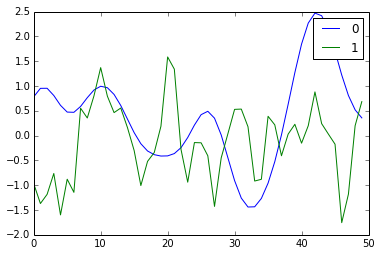

In [231]:
#Latent Gaussian Processes:
u = np.zeros((P,N))
for p in range(P):
    u[p,:] = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=K[p])
    plt.plot(u[p,:],label=p)
plt.legend()

In [232]:
# Output Values:
Y = phi.dot(u) + s2


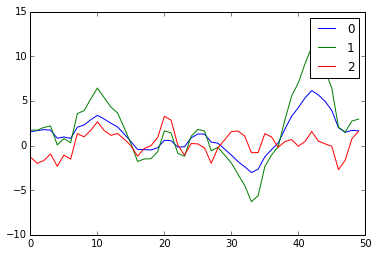

In [233]:
for c in range(C):
    plt.plot(Y[c,:],label=c)
plt.legend()

## Now objective is to variationally approximate and recover Phi 

Variational Inducing Updates are:


In [315]:
## get random inducing point
P=2
noOfInductions = 20
n = np.random.choice(x,size=noOfInductions)
sparseY = np.mat(Y[:,n.astype(int)])
# Create Matrices
Knn = list()
KnN = list()
KnnInv = list()
KNN = list()
for i in range(P):
    Knn.append(Kernel.generateKernel(Kernel.exponenQuad,n,n,l=1,a=1))
    KnN.append(Kernel.generateKernel(Kernel.exponenQuad,n,x,l=1,a=1))
    KNN.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1,a=1))
    KnnInv.append(np.linalg.inv(Knn[i]))
    print KnN[i].shape,Knn[i].shape,KnnInv[i].shape
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHat = np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P))
uHatSparseMeans = np.random.normal(loc=0,scale=1,size=(P,noOfInductions))
uHatVs = [np.ones((noOfInductions,noOfInductions))for p in range(P)]
uHat = np.ones((P,noOfInductions))

(20, 50) (20, 20) (20, 20)
(20, 50) (20, 20) (20, 20)


### Variational Updates are:

#### For U's:

$$u_p = N(\Sigma_{p}^{-1}K_{n}^{-1}K_{Nn}Z_p,\Sigma_{p})$$
where $\Sigma_{p} = K_{n}^{-1} + \frac{1}{\sigma^2}K_{n}^{-1}K_{nN}UK_{Nn}K_{n}^{-1}$
and $Z_p = \sum_{c}^{C}<\phi_{cp}>(y_c - \sum_{i}^{P/p}<\phi_{ci}><u_{ip}>)$, 
and $U_p = \sum_{c}^{C}<\phi_{cp}^2>$

#### For $\phi$:

$\phi = N(\Sigma_{\phi}^{-1}V_{\phi}y<U>^T, \Sigma{f})$
where $\Sigma_{\phi} = (V_{\phi}^{-1} + I )^-1$
and $V_{\phi} = <U><U>^T\sigma^2$


In [316]:
#Single variation update:

#uExp = np.mat(uHatMeans[:,None] * np.ones((P,N)))
uExp = uHatSparseMeans
## Variation Update for Phi
Vf= uExp.dot(uExp.T)
Sigmaf = np.mat(Vf + np.ones((c,c)))
SigmafInv = np.linalg.inv(Sigmaf)
phiHatMean = sparseY * uExp.T * SigmafInv
phiExp = phiHatMean * np.ones((c,P))
for p in range(P):
    summationZ = 0
    summationPhiSq = 0
    for c in range(C):
        #findterm for U
        summationPhiSq += phiExp[c,p]**2
        #Error term for Z
        excludeP = np.arange(P)!=p
        errTerm = sparseY[c,:] - phiExp[c,excludeP].dot(uExp[excludeP,:])
        summationZ += phiExp[c,p]*errTerm
    Zp = summationZ
    Up = np.mat(np.diag(np.ones(N)*summationPhiSq))
    SigmaP = KnnInv[p] + KnnInv[p] * KnN[p] * Up * KnN[p].T * KnnInv[p] 
    MuP = np.linalg.inv(SigmaP)*KnnInv[p]*KnN[p]*Zp.T
    ## Variational Updates for individual u's
    uHatMeans[p] = MuP
    uHatSigmas[p] = SigmaP
## Update U expectations
    
    

ValueError: matrices are not aligned

In [317]:
print np.linalg.inv(SigmaP).shape,KnnInv[p].shape,KnN[p].shape,Zp.T.shape

(20, 20) (20, 20) (20, 50) (20, 1)


In [311]:
Yhat = Y[:,n.astype(int)]

In [312]:
Yhat

array([[ 1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.66628876,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182],
       [ 1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.70976584,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811],
       [-1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.99535756,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901]])